# SHANGRLA - Fisher Combination

This hypothetical election follows the example from CORLA18's `fisher_combined_pvalue.ipynb`. 

We'll set up a hypothetical election and a single sample of ballots to illustrate how to combine a ballot-polling audit with a ballot-comparison audit using Fisher's combining function.

There are two strata. One contains every CVR county and the other contains every no-CVR county.
There were 11,000 ballots cast in the election, 10,000 in the CVR stratum and 1,000 in the no-CVR stratum.

In the CVR stratum, there were 4,550 votes reported for A, 4,950 votes for candidate B, and 500 invalid ballots.
In the no-CVR stratum, there were 750 votes reported for A, 150 votes for B, and 100 invalid ballots.
A won overall, with 5,300 votes to B's 5,1000, but not in the CVR stratum.
The reported vote margin between A and B is 200 votes, a "diluted margin" of $200/11,000 = 1.8\%$.


Candidate | Stratum 1 | Stratum 2 | total 
---|---|---|---
A | 4,550 | 750 | 5,300
B | 4,950 | 150 | 5,100
Ballots | 10,000 | 1,000 | 11,000
Diluted margin | -4% | 60% | 1.8%

We want to limit the risk of certifying an incorrect outcome to at most $\alpha=10\%$. 

In the CVR stratum, we sample 500 ballots and find one 1-vote overstatement.

In the no-CVR stratum, we sample 250 ballots. We are unusually lucky and the vote proportions in the sample match those in the population. There are $187$ ballots for A and $37$ ballots for B. 

In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import scipy.optimize
import json
from assertion_audit_utils import TestNonnegMean

from fishers_combination import fisher_combined_pvalue, maximize_fisher_combined_pvalue, calculate_beta_range, create_modulus

import matplotlib.pyplot as plt

In [2]:
N1 = 10000
N2 = 1000
N_w1 = 4550
N_l1 = 4950
N_w2 = 750
N_l2= 150

n1 = 500
n2 = 250

Sample array

In [3]:
# cvr/mvr arrays
cvr_array_c = np.array([0]*int(n1*N_l1/N1)+[1]*int(n1*N_w1/N1)+ [1/2]*int(n1*(N1-N_l1-N_w1)/N1 + 1))

# 0 o1, o2, u1, u2
#cvr_array_m = np.array([0]*int(n1*N_l1/N1)+[1]*int(n1*N_w1/N1)+ [1/2]*int(n1*(N1-N_l1-N_w1)/N1 + 1))

# 1 o1
cvr_array_m = np.array([0]*int(n1*N_l1/N1)+[1]*int(n1*N_w1/N1)+ [1/2]*int(n1*(N1-N_l1-N_w1)/N1)+[0])

overstatement = cvr_array_c-cvr_array_m
margin = 2*np.mean(cvr_array_c)-1
cvr_array = (1-overstatement)/(2-margin)

nocvr_array = np.array([0]*int(n2*N_l2/N2)+[1]*int(n2*N_w2/N2)+ [1/2]*int(n2*(N2-N_l2-N_w2)/N2 + 1))

Define functions for computing $P$-values with input $\beta$

In [4]:
g_0 = 0.1
upper_bound = 1

risk_fns = ["kaplan_martingale", "kaplan_martingale"]
cvr_pvalue_0 = lambda t_0: TestNonnegMean.kaplan_martingale(x=cvr_array, N=N1+N2, \
                t=1/2 + (t_0 - 1/2)/(2*upper_bound - margin), random_order=False)[0]
cvr_pvalue = lambda beta: cvr_pvalue_0(t_0=beta*(N1+N2)/N1)
nocvr_pvalue = lambda beta: TestNonnegMean.kaplan_martingale(x=nocvr_array, N=N1+N2, \
                t=(1/2-beta)*(N1+N2)/N2, random_order=False)[0]

#risk_fns = ["kaplan_kolmogorov", "kaplan_kolmogorov"]
#cvr_pvalue_0 = lambda t_0: TestNonnegMean.kaplan_kolmogorov(x=np.array(cvr_array), \
#               N=N1+N2, t=1/2 + (t_0 - 1/2)/(2*upper_bound - margin), g=g_0, random_order=False)
#cvr_pvalue = lambda beta: cvr_pvalue_0(t_0=beta*(N1+N2)/N1) 
#nocvr_pvalue = lambda beta: TestNonnegMean.kaplan_kolmogorov(x=nocvr_array, N=N1+N2, \
#               t=(1/2-beta)*(N1+N2)/N2, g=g_0, random_order=False)

Maximizing the $P$-value over $\beta$

beta limits: 0.40909090909090906 0.5


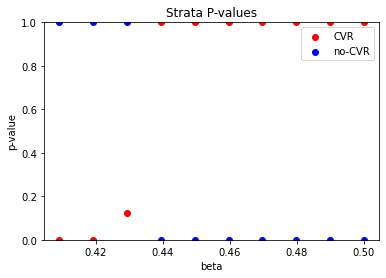

In [5]:
(beta_lower, beta_upper) = calculate_beta_range(N1, N2)
beta_test_count_0 = 10

test_betas = np.array(np.linspace(beta_lower, beta_upper, beta_test_count_0))
print("beta limits:", beta_lower, beta_upper)
fisher_pvalues = []
cvr_pvalues = []
nocvr_pvalues = []
for b in test_betas:
    cvr_pvalues.append(cvr_pvalue(b))
    nocvr_pvalues.append(nocvr_pvalue(b))
    fisher_pvalues.append(fisher_combined_pvalue([cvr_pvalues[-1], nocvr_pvalues[-1]]))

plt.scatter(test_betas, cvr_pvalues, color='r', label='CVR')
plt.scatter(test_betas, nocvr_pvalues, color='b', label='no-CVR')
plt.title('Strata P-values')
plt.legend()
plt.xlabel('beta')
plt.ylabel('p-value')
plt.ylim(0, 1)
plt.show()

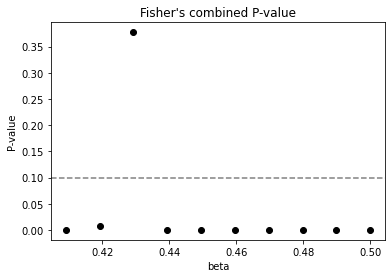

(max p-value, beta):  (0.37743512227214004, 0.4292929292929293)


In [6]:
plt.scatter(test_betas, fisher_pvalues, color='black')
plt.axhline(y=0.1, linestyle='--', color='gray')
plt.title("Fisher's combined P-value")
plt.xlabel("beta")
plt.ylabel("P-value")
plt.show()
print('(max p-value, beta): ', (max(fisher_pvalues), test_betas[fisher_pvalues.index(max(fisher_pvalues))]))

In [7]:
mod = create_modulus(risk_fns, N1, N2, n1, n2, margin, upper_bound, g_0, cvr_array, nocvr_array)

m = maximize_fisher_combined_pvalue(N1, N2, pvalue_funs=[cvr_pvalue, nocvr_pvalue], beta_test_count=10, modulus=mod, alpha=0.10, feasible_beta_range=(beta_lower, beta_upper))

print(json.dumps(m, indent=4))

{
    "max_pvalue": 0.37743512227214004,
    "min_chisq": 4.216990804441813,
    "allocation beta": 0.4292929292929293,
    "tol": null,
    "stepsize": 0.008264462809917357,
    "refined": false
}


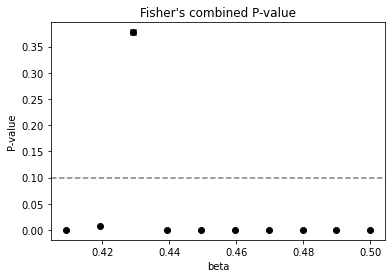

In [8]:
plt.scatter(test_betas, fisher_pvalues, color='black')
plt.scatter(m['allocation beta'], m['max_pvalue'], color='black', marker='x')
plt.axhline(y=0.1, linestyle='--', color='gray')
plt.title("Fisher's combined P-value")
plt.xlabel("beta")
plt.ylabel("P-value")
plt.show()